# Image Segmentation using K-means

Applying the updated kmeans clustering algorithm on images to segment them by RGB values

## Imports

In [1]:
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt

from scipy import stats

## Updated k-means Algorithm

In [2]:
def cluster_points(X, mu):
    clusters  = {}
    labels = [[]] * len(X)
    index = 0
    
    for x in X:
        bestmukey = min([(i[0], np.linalg.norm(x-mu[i[0]])) \
                    for i in enumerate(mu)], key=lambda t:t[1])[0]
        try:
            clusters[bestmukey].append(x)
            labels[index] = [bestmukey]
        except KeyError:
            clusters[bestmukey] = [x]
            labels[index] = [bestmukey]
            
        index += 1

    return clusters, labels

def reevaluate_clusters(X, clusters, labels, tol):
    '''
    Function to correct clustering errors from Lloyd's algorithm. 
    
    Calculate the kstest statistic (pvalue) of all vectors with 
    their average cluster vector to determine if the vector belongs 
    to the same distribution as the rest of the cluster. 
    
    Correct errors arising in the kmeans clustering by all vectors to 
    clusters with whose average cluster vector they have the 
    highest kstest statistic (pvalue).
    '''
    avg_vecs = {}
    pvals = {}
    removed = []
    index = 0
    removed_indices = []
    
    # Store average cluster vectors 
    for key in clusters.keys():
        avg_vecs[key] = sum(clusters[key]) / len(clusters[key])
    
    # Remove poorly clusterd vector from cluster 
    for key in clusters.keys():
        for x in X:
            # If kstest pvalue lower than tolerance, vector is poorly clustered
            stat = stats.kstest(x, avg_vecs[key]).pvalue
            if stat < tol:
                try:
                    clusters[key].remove(x)
                    # Store removed vectors to be re-clustered
                    removed.append(x)
                    labels[index] = []
                    removed_indices.append(index)
                    index += 1
                except ValueError:
                    pass
    
    # Re-distribute removed vectors to the cluster with max kstest pvalue
    for i in range(len(removed)):
        vec = removed[i]
        for key in clusters.keys():
            # Store pvalue of kstest stat for each vector 
            pvals[key] = stats.kstest(vec, avg_vecs[key]).pvalue
        
        temp = max(pvals.values())
        key = [key for key in pvals if pvals[key] == temp][0]
        clusters[key].append(vec)
        labels[removed_indices[i]] = [key]
    
    # Return re-evaluated clusters
    return clusters, labels
 
def reevaluate_centers(mu, clusters):
    newmu = []
    keys = sorted(clusters.keys())
    for k in keys:
        newmu.append(np.mean(clusters[k], axis = 0))
    return newmu
 
def has_converged(mu, oldmu):
    return (set([tuple(a) for a in mu]) == set([tuple(a) for a in oldmu]))
 
def kmeans(X, K, max_iter=100, tol=0.95, seed=42):
    # Plant seed to track random samples
    random.seed(seed)
    # Initialize to K random centers
    oldmu = random.sample(X, K)
    mu = random.sample(X, K)
    count = 0
    labels = []
    while not has_converged(mu, oldmu):
        oldmu = mu
        # Assign all points in X to clusters
        clusters, labels = cluster_points(X, mu)
        # Re-evaluate clusters
        clusters, labels = reevaluate_clusters(X, clusters, labels, tol)
        # Calculate accuracy
        mu_means = np.array(pd.Series(mu).apply(lambda x: x.mean()))
        print('Iteration {}: {}'.format(count, mu_means))
        # If maximum accuracy is achieved, stop iterating
        if count == max_iter:
            break
        # Increase number of iterations by 1
        count += 1
        # Reevaluate centers
        mu = reevaluate_centers(oldmu, clusters)        
    return mu, clusters, labels

## Run Algorithm on Image

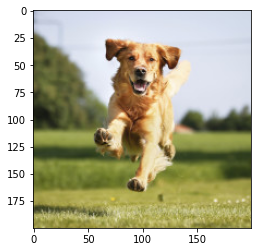

In [3]:
image = cv2.imread("image.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [4]:
# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = image.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)
print(pixel_values.shape)

(40000, 3)


In [5]:
k = 3
centers, clusters, labels = kmeans(list(pixel_values), k)

Iteration 0: [114.          85.33333588 230.66667175]
Iteration 1: [132.9801178   71.88954926 222.27838135]
Iteration 2: [134.42770386  72.39245605 223.08544922]
Iteration 3: [135.08924866  72.91748047 223.23982239]
Iteration 4: [135.43421936  73.2352066  223.28666687]
Iteration 5: [135.62927246  73.44164276 223.32572937]
Iteration 6: [135.8094635   73.54767609 223.36260986]
Iteration 7: [135.87187195  73.58808136 223.38183594]
Iteration 8: [135.92655945  73.62393188 223.39744568]
Iteration 9: [135.93252563  73.62636566 223.40016174]
Iteration 10: [135.93493652  73.62884521 223.40016174]


In [8]:
centers = np.uint8(centers)
labels = np.array(labels).flatten()

In [9]:
# convert all pixels to the color of the centroids
segmented_image = centers[labels]
# reshape back to the original image dimension
segmented_image = segmented_image.reshape(image.shape)

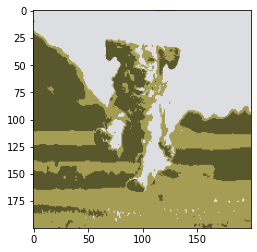

In [10]:
# show the image
plt.imshow(segmented_image)
plt.show()